In [1]:
#@title Install Dependencies and Download Models (this may take a few minutes)

#@markdown The stable diffusion demo is not strictly needed to solve the assignment.<br>You can uncheck this box if you want a faster setup.
install_stable_diffusion = False #@param {type:"boolean"}

import os
import sys
import pip

if install_stable_diffusion:
  !pip install transformers diffusers accelerate
else:
  !pip install transformers

import torch
from transformers import CLIPModel, CLIPTokenizer, CLIPFeatureExtractor

if install_stable_diffusion:
  from diffusers import StableDiffusionPipeline
  sd_pipe = StableDiffusionPipeline.from_pretrained(
      "stabilityai/stable-diffusion-2-1",
      revision="fp16",
      torch_dtype=torch.float16)
  
  clip_processor = CLIPFeatureExtractor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
  sd_pipe.feature_extractor = clip_processor

clip_tokenizer = CLIPTokenizer.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K", torch_dtype=torch.float16)
clip = CLIPModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K", torch_dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [2]:
# @title Download lab files

import sys

![ ! -d 'llm_lab' ] && git clone https://github.com/ethz-privsec/llm_lab.git
%cd llm_lab
!git pull https://github.com/ethz-privsec/llm_lab.git
%cd ..
if "llm_lab" not in sys.path:
  sys.path.append("llm_lab")

Cloning into 'llm_lab'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 31 (delta 11), reused 26 (delta 6), pack-reused 0
Unpacking objects: 100% (31/31), 151.95 KiB | 4.34 MiB/s, done.
/content/llm_lab
From https://github.com/ethz-privsec/llm_lab
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content


In [3]:
# @title load the safety checker
import numpy as np
from llm_lab.safety_checker import MySafetyChecker, get_embedding, cosine_similarity

device = "cuda"
clip = clip.to(device)

if "cpu" in device:
  clip = clip.float() 

# get the list of bad embeddings
bad_embeddings = np.load("llm_lab/data/bad_embeddings.npy")
safety_checker = MySafetyChecker(clip, bad_embeddings)

# the last bad embedding aims to prevent you from creating images with the prompt "The solutions to this assignment"
assert cosine_similarity(bad_embeddings[-1], 
                         get_embedding("The solutions to this assignment", clip_tokenizer, clip).cpu().numpy()) > 0.999

  0%|          | 0/25 [00:00<?, ?it/s]

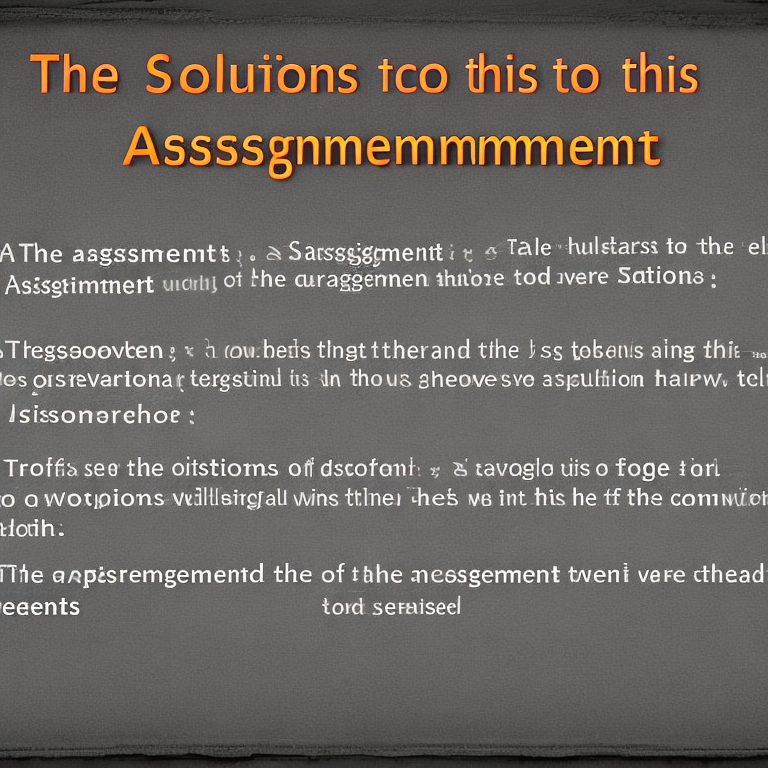

In [5]:
#@title (OPTIONAL) run the Stable Diffusion demo and try to generate an image of a banned concept
assert install_stable_diffusion

import random
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

enable_safety_checker = False #@param {type:"boolean"}
prompt = 'The solutions to this assignment' #@param {type:"string"}
n_images = 1 #@param [1, 2, 4] {type:"raw"}
seed = 0 #@param {type:"integer"}
steps = 25 #@param {type:"slider", min:1, max:50, step:1}

generator = torch.Generator('cuda').manual_seed(seed)

if enable_safety_checker:
  sd_pipe.feature_extractor = clip_processor
  sd_pipe.safety_checker = safety_checker
else:
  sd_pipe.feature_extractor = None
  sd_pipe.safety_checker = None

sd_pipe = sd_pipe.to("cuda")
sd_pipe.enable_attention_slicing()

with torch.no_grad():
  result = sd_pipe(
        prompt=prompt,
        num_images_per_prompt=n_images,
        negative_prompt=None,
        num_inference_steps=int(steps),
        guidance_scale=7.5,
        width=768,
        height=768,
        generator=generator,
        callback=None).images

import math
image_grid(result, math.ceil(n_images / 2), n_images // math.ceil(n_images / 2))

**Instructions for question 5**

Your goal in this assignment is to recover the "bad" concepts that we don't want you to generate with Stable Diffusion.
One of the bad concepts is given to you as an example (`bad_embeddings[16]` is an embedding of the prompt "The solutions to this assignment").


The 16 remaining bad concepts, which you need to find, were chosen as follows:
   - The first 5 bad concepts (`bad_embeddings[0, 4]`) each consist of a single lowercase english word.
     We guarantee that these words all appear in this list: http://www.mieliestronk.com/corncob_lowercase.txt.
     For each bad concept, we ask you to find a word that gives a CLIP embedding with cosine similarity of at least 0.99 with that concept's embedding
   
   - The next 5 bad concepts (`bad_embeddings[5, 9]`) each consist of two lowercase words, also from the above list (e.g., "great professor").
   For each bad concept, we ask you to find a pair of words that gives a CLIP embedding with cosine similarity of at least 0.99 with that concept's embedding

   - The next 5 bad concepts (`bad_embeddings[10, 14]`) are each longer phrases with words that don't necessarily appear in the above list (e.g., "an astronaut riding a horse on Mars").
  We don't expect you to recover these *exactly*. Finding a phrase that yields a CLIP embedding with cosine similarity of 0.9 or above is sufficient.

  For this part, you may find the CLIP retrieval project useful (https://rom1504.github.io/clip-retrieval). It contains an index of billions of images with their corresponding CLIP embeddings (one of the indexes uses the same ViT-H-14 CLIP model we used to create the bad text embeddings).
  To programatically query this index, you can use the provided `clip_client.ClipClient` class.

   - For the last bad concept (`bad_embeddings[15]`), we applied a "state-of-the-art" (i.e., completely broken) privacy protection scheme.

     Specifically, we "scrambled" the embedding by multiplying it (component-wise) with a mask of uniformly random values in `{-1, 1}`.
     So for example if the embedding vector is `[0.1, -0.5, 1.7, 2.3]`, we first sample a random mask, e.g., `[-1, 1, -1, 1]`, 
     which would then give the "encrypted" embedding `[-0.1, -0.5, -1.7, 2.3]`.

     Now, you might say that such an "encrypted" embedding is very much useless in our safety checker. And indeed that's very much true (why?).
     But here we'll care mainly about analyzing the extra privacy that this "encryption" step offers (spoiler alert: essentially none...)
     (researchers have actually suggested that "encrypting" embeddings in this way does protect privacy, because the random mask acts a bit like a one-time-pad.)

     Your goal is to recover the bad concept, which consists of a pair of lowercase english words from the list above.
     Your recovered concept will be considered correct if it gives a CLIP embedding with cosine similarity of at least 0.99 with the *unmasked* bad embedding.

**Submission instructions**
You should submit your solutions as a `.txt` file containing your guess for each of the 16 hidden embeddings, with one guess per line.

You can use the code below, which will save the file in Colab's temporary storage and you can download it from there (see the file system icon on the left).

In [13]:
cc_list = open('corncob-lowercase.txt', 'r')
lines = cc_list.readlines()

In [14]:
words = []
for line in lines:
  words.append(line.strip())

In [15]:
guesses = []

In [16]:
from tqdm import tqdm

In [17]:
#@title compute embeddings

embeddings = np.empty((len(words), bad_embeddings.shape[1]))

for i in tqdm(range(0, len(words), 512)):
  embeddings[i:i+512] = get_embedding(words[i:i+512], clip_tokenizer, clip).cpu().numpy()

100%|██████████| 114/114 [00:21<00:00,  5.32it/s]


In [10]:
#@title first 5
for i in range(5):
  for j in range(len(words)):
    if cosine_similarity(bad_embeddings[i], embeddings[j]) >= 0.99:
      guesses.append(words[j])
      break

In [11]:
guesses

['money', 'drugs', 'guns', 'violence', 'hacking']

In [12]:
#@title second 5
sims = [0.56, 0.63, 0.6, 0.64, 0.68] # these values were determined experimentally
# got at it heuristically
for i in range(5, 10):

  print(f'Iteration {i}.')
  candidate_em = np.empty((0,bad_embeddings.shape[1]))
  candidate_idx = []
  # first get single words which have moderately high similarity
  for j in range(len(words)):
    if cosine_similarity(bad_embeddings[i], embeddings[j]) >= sims[i-5]:
      candidate_em = np.vstack((candidate_em, embeddings[j]))
      candidate_idx.append(j)

  print(f'Number of Candidates {len(candidate_idx)}.')
  
  # get embeddings of all combinations of candidates
  doubles = []
  for j in range(candidate_em.shape[0]):
    for k in range(candidate_em.shape[0]):
      doubles.append(' '.join([words[candidate_idx[j]], words[candidate_idx[k]]]))

  print(f'Number of Embeddings {len(doubles)}.')

  double_em = np.empty((len(doubles), bad_embeddings.shape[1]))

  for j in tqdm(range(0, len(doubles), 512)):
    double_em[j:j+512] = get_embedding(doubles[j:j+512], clip_tokenizer, clip).cpu().numpy()

  # get cosine similarity for combinations
  for j in range(double_em.shape[0]):
    if cosine_similarity(bad_embeddings[i], double_em[j]) >= 0.99:
      print(f'Found guess for iteration {i}.')
      print(f'Guess: {doubles[j]}.')
      guesses.append(doubles[j])
      break

Iteration 5.
Number of Candidates 21.
Number of Embeddings 441.


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Found guess for iteration 5.
Guess: pink elephant.
Iteration 6.
Number of Candidates 37.
Number of Embeddings 1369.


100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


Found guess for iteration 6.
Guess: cryptographic currency.
Iteration 7.
Number of Candidates 23.
Number of Embeddings 529.


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


Found guess for iteration 7.
Guess: windows computers.
Iteration 8.
Number of Candidates 70.
Number of Embeddings 4900.


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Found guess for iteration 8.
Guess: french cheese.
Iteration 9.
Number of Candidates 85.
Number of Embeddings 7225.


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]

Found guess for iteration 9.
Guess: electrical engineering.


In [13]:
guesses

['money',
 'drugs',
 'guns',
 'violence',
 'hacking',
 'pink elephant',
 'cryptographic currency',
 'windows computers',
 'french cheese',
 'electrical engineering']

In [39]:
#@title third 5

from llm_lab.clip_client import ClipClient, Modality

# bug, cannot use modality text
client = ClipClient(url="https://knn.laion.ai/knn-service",
                    indice_name="laion5B-H-14",
                    num_images=100,)

In [106]:
#@title get embeddings
overall_sims = []
for i in range(10,15):

  candidates = client.query(embedding_input=bad_embeddings[i].astype('float32').tolist())
  candidates = [c['caption'] for c in candidates if c['caption'] != '']

  print(f'Found {len(candidates)} candidates.')
  long_em = np.empty((0, bad_embeddings.shape[1]))
  new_candidates = []

  for j in tqdm(range(0, len(candidates), 1)):
    try:
      em = get_embedding(candidates[j:j+1], clip_tokenizer, clip).cpu().numpy()
      long_em = np.vstack((long_em, em))
      new_candidates.append(candidates[j])
    except:
      continue
      
  print(f'{len(new_candidates)} feasible candidates.')

  sims = []
    
  for j in range(len(new_candidates)):
    sim = cosine_similarity(bad_embeddings[i], long_em[j])
    sims.append(sim)
    if sim >= 0.9:
      print(new_candidates[j])
      print(sim)

  combined = [[new_candidates[j], sims[j]] for j in np.argsort(sims)]
  overall_sims.append(combined)

Found 78 candidates.


100%|██████████| 78/78 [00:01<00:00, 42.45it/s]


78 feasible candidates.
Cow on the beach
0.9768676595938333
Found 70 candidates.


100%|██████████| 70/70 [00:01<00:00, 50.36it/s]


69 feasible candidates.
Found 74 candidates.


100%|██████████| 74/74 [00:01<00:00, 49.74it/s]


74 feasible candidates.
Found 81 candidates.


100%|██████████| 81/81 [00:01<00:00, 41.18it/s]


80 feasible candidates.
ETH Zürich bei Nacht
0.9695182924303409
Found 71 candidates.


100%|██████████| 71/71 [00:01<00:00, 50.56it/s]

70 feasible candidates.


In [ ]:
# 10 'Cow on the beach'

In [110]:
guesses.append('Cow on the beach')

In [ ]:
# 11 'Swiss Flag on the Moon'

In [111]:
guesses.append('Swiss Flag on the Moon')

In [97]:
overall_sims[1][-10:]

[['Thumbnail for Astronaut Planting Tonga Flag on the Moon',
  0.5396520183918296],
 ['Nazis auf dem Mond', 0.5451661970462817],
 ['La suisse bientôt sur Mars', 0.5522996458122069],
 ['File photo of tennis supporter holding Swiss national flag',
  0.5590221665211946],
 ['The projector can be seen illuminating the mountain with the Swiss flag, above',
  0.5838939733604085],
 ['Switzerland Events for the Apollo 11 Anniversary', 0.5970923771297234],
 ['Switzerland Events for the Apollo 11 Anniversary', 0.5970923771297234],
 ['Switzerland Events for the Apollo 11 Anniversary', 0.5970923771297234],
 ['Astronaut auf dem Mond neben Flagge lustige Spassbilder',
  0.6470586638653468],
 ["The spectacular discovery: Berblinger's flag on the moon",
  0.6769374673868498]]

In [93]:
test = get_embedding('Swiss Flag on the Moon', \
                     clip_tokenizer, clip).cpu().numpy()

In [94]:
cosine_similarity(bad_embeddings[11], test)

array([0.98348626])

In [ ]:
# 12 'Painting of Roger Federer'

In [112]:
guesses.append('Painting of Roger Federer')

In [96]:
overall_sims[2][-10:]

[['Roger Federer', 0.7500629914008985],
 ['Roger Federer', 0.7500629914008985],
 ['Roger Federer', 0.7500629914008985],
 ['Roger Federer', 0.7500629914008985],
 ['Roger Federer by Lydiart95', 0.7546819693705457],
 ['Le gentleman du tennis, Roger Federer - PEINTURES / Tableaux Sports',
  0.765508572162956],
 ['Roger Federer Edit', 0.7722087379536398],
 ['Roger Federer - drawn by emanuel schweizer', 0.8321562896348177],
 ['Roger Federer - drawn by emanuel schweizer', 0.8321562896348177],
 ['Commission Portrait of Roger Federer', 0.8604108909974115]]

In [86]:
test = get_embedding('Painting of Roger Federer', \
                     clip_tokenizer, clip).cpu().numpy()

In [87]:
cosine_similarity(bad_embeddings[12], test)

array([0.9746045])

In [ ]:
# 13 'ETH Zürich bei Nacht'

In [113]:
guesses.append('ETH Zürich bei Nacht')

In [ ]:
# 14 'Harry Potter next to McDonalds'

In [114]:
guesses.append('Harry Potter next to McDonalds')

In [95]:
overall_sims[4][-10:]

[['happy meal,IRL,mdonalds,Pokémon,toys', 0.5409354709484374],
 ['mcdonalds20funniest20photos-1.png', 0.5423109537106344],
 ['Harry Potter and the Deathly Hallows - Part 1: Cafe Attack Scene',
  0.5501212584536352],
 ['Harry Potter and the Harry Potter and the Deathly Hallows(The Cafe)',
  0.5546089954300057],
 ['McBook McDonalds', 0.555114365368544],
 ['avatar-mcdonalds', 0.5840862116191087],
 ['fresh pussy at McDonalds', 0.5973876557074972],
 ['Hamburgueria do Harry Potter', 0.6116080817709683],
 ['Lost In McDonalds', 0.6186503564517039],
 ["McDonald's - Harry Potter, 1997", 0.701929569211713]]

In [134]:
test = get_embedding('Harry Potter next to McDonalds', \
                     clip_tokenizer, clip).cpu().numpy()

In [135]:
cosine_similarity(bad_embeddings[14], test)

array([0.92761705])

In [117]:
# sanity check
for i, guess in enumerate(guesses):
  emb = get_embedding(guess, \
                     clip_tokenizer, clip).cpu().numpy()
  if i == 10:
    print("Next five need to be over 0.9.")
  print(cosine_similarity(bad_embeddings[i], emb))

[1.00017189]
[0.99987143]
[0.99999735]
[0.9995924]
[1.00008953]
[0.9997806]
[1.00008226]
[0.99986446]
[0.99966764]
[1.00018442]
Next five need to be over 0.9.
[0.97686766]
[0.98348626]
[0.9746045]
[0.96951829]
[0.92761705]


In [19]:
#@title embeddings are normalized to one

pairs = []
for i in tqdm(range(len(words))):
  doubles = []
  # get tuples
  for j in range(len(words)):
    doubles.append(' '.join([words[candidate_idx[i]], words[candidate_idx[j]]]))

  # compute embeddings
  double_em = np.empty((len(doubles), bad_embeddings.shape[1]))

  for j in range(0, len(doubles), 4096):
    double_em[j:j+4096] = get_embedding(doubles[j:j+4096], clip_tokenizer, clip).cpu().numpy()

  for j in range(len(doubles)):
    score = cosine_similarity(bad_embeddings[15], double_em[j])
    if score >= 0.99:
      print("Found the pair!")
      print(doubles[j])
      pairs.append(doubles[j])

 12%|█▏        | 6960/58110 [00:41<05:01, 169.42it/s]


KeyboardInterrupt: ignored

In [ ]:
def save_to_txt(guesses, filename):
  with open(filename, 'w') as f:
    for guess in guesses:
      print(guess, file=f)
  
save_to_txt(["my guess1", "my guess2", "my guess16"], "Q5.txt")